# Assignment 3.1

## Reading S3 bucket into SageMaker Studio

In [2]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

s3_client = boto3.client("s3")

BUCKET='ads508projectbucket'

# For Country_and_Subscriber_df
Country_and_Subscriber_Key='Aggregated_Metrics_By_Country_And_Subscriber_Status.csv'
Country_and_Subscriber_response = s3_client.get_object(Bucket=BUCKET, Key=Country_and_Subscriber_Key)
Country_and_Subscriber_df = pd.read_csv(Country_and_Subscriber_response.get("Body"))

# For Video_df
Video_Key='Aggregated_Metrics_By_Video.csv'
Video_response = s3_client.get_object(Bucket=BUCKET, Key=Video_Key)
Video_df = pd.read_csv(Video_response.get("Body"))

# For Comments_df
Comments_Key='All_Comments_Final.csv'
Comments_response = s3_client.get_object(Bucket=BUCKET, Key=Comments_Key)
Comments_df = pd.read_csv(Comments_response.get("Body"))

# For Performance_df
Performance_Key='Video_Performance_Over_Time.csv'
Performance_response = s3_client.get_object(Bucket=BUCKET, Key=Performance_Key)
Performance_df = pd.read_csv(Performance_response.get("Body"))

## Exploring Data

#### Country_and_Subscriber_df

In [3]:
Country_and_Subscriber_df.head()

,Video Title,External Video ID,Video Length,Thumbnail link,Country Code,Is Subscribed,Views,Video Likes Added,Video Dislikes Added,Video Likes Removed,User Subscriptions Added,User Subscriptions Removed,Average View Percentage,Average Watch Time,User Comments Added
0,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,HK,True,23,1,0,0,2,0,0.671870,39.640348,0
1,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,ME,True,3,0,0,0,0,0,0.498870,29.433333,0
2,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,RW,True,2,0,0,0,0,0,0.681780,40.225000,0
3,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,US,True,979,81,6,8,16,4,0.694854,40.996389,0
4,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,DE,False,75,3,0,1,0,0,0.661515,39.029373,0


Already, we can see multiple variables that can be removed prior to building a model. 'Thumbnail link' can be removed, but we might want to include 'Video Title' to see if certain key phrases can increase video views. 'External Video ID' is present in each data frame, so this will be kept to join the data frames together in the future prior to modeling. Once this is accomplished, "External Video ID' will be removed to stop it from hindering model performance. 

In [51]:
Country_and_Subscriber_df.dtypes

Video Title                    object
External Video ID              object
Video Length                    int64
Thumbnail link                 object
Country Code                   object
Is Subscribed                    bool
Views                           int64
Video Likes Added               int64
Video Dislikes Added            int64
Video Likes Removed             int64
User Subscriptions Added        int64
User Subscriptions Removed      int64
Average View Percentage       float64
Average Watch Time            float64
User Comments Added             int64
dtype: object

Here are the data types of each feature. Most of the data types are int, with only 1 boolean and 2 floats. The most important string data type in our data set will either be 'Country Code' or 'Video Title' depending on if we can extract key words from the title or not.

<function matplotlib.pyplot.show(*args, **kw)>

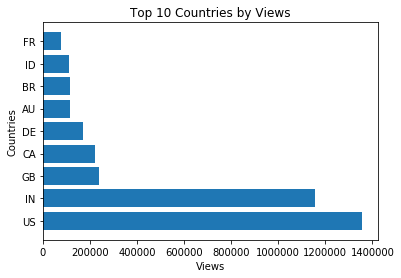

In [32]:
# Creating plot of views by country
grouped_country = Country_and_Subscriber_df.groupby(by = 'Country Code', as_index = False).sum()
grouped_country_sort = grouped_country.sort_values(by = 'Views', ascending = False)
xAxis = grouped_country_sort.loc[:,'Country Code'][:9]
yAxis = grouped_country_sort.loc[:,'Views'][:9]
plt.barh(xAxis, yAxis)
plt.title("Top 10 Countries by Views")
plt.xlabel('Views')
plt.ylabel('Countries')
plt.show

From this chart, we can see most of the data will come from these top 10 countries. This can introduce bias to our data set due to views mostly coming from a few countires (out of the 234 countires that view these videos). This will be an important aspect to consider going forward due to our model most likely giving insights that will reach American and Indian audiences more so than other countires. 

<function matplotlib.pyplot.show(*args, **kw)>

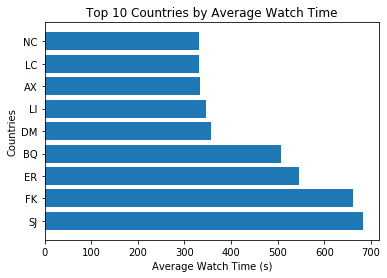

In [37]:
# Creating plot of average watch time by country
grouped_country = Country_and_Subscriber_df.groupby(by = 'Country Code', as_index = False).mean()
grouped_country_sort = grouped_country.sort_values(by = 'Average Watch Time', ascending = False)
xAxis = grouped_country_sort.loc[:,'Country Code'][:9]
yAxis = grouped_country_sort.loc[:,'Average Watch Time'][:9]
plt.barh(xAxis, yAxis)
plt.title("Top 10 Countries by Average Watch Time")
plt.xlabel('Average Watch Time (s)')
plt.ylabel('Countries')
plt.show

None of the countries with the most views appeared on this list, indicating that average watch time by country can be influenced by a smaller number of people watching. The less viewers in a country, the higher the variance.

In [73]:
# Making 'Video Title' into 1 long string to find the 10 most common words
data_set = ' '.join(Country_and_Subscriber_df['Video Title'].tolist())

# split() returns list of all the words in the string
split_it = data_set.split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
print(most_occur)

[('Data', 47211), ('Science', 34319), ('-', 14343), ('to', 10057), ('How', 9845), ('a', 9839), ('Your', 7708), ('I', 7393), ('Projects', 7174), ('The', 6526)]


The 3 most common words that are not dash or an article are 'Data,' 'Science,' and 'How.' In the future, we can create boolean features of these words to indicate if they appear in the title or not and see how well they do at helping predict views and likes.